### Finetuning and training the Pytorch-i3d model
Code taken from: https://github.com/piergiaj/pytorch-i3d/blob/master/train_i3d.py 

Note: This code was written for PyTorch 0.3. Version 0.4 and newer may cause issues.

To-dos:
1. extract videos and add labels (the line `return images, 0` assigns the label 0 to every images in the code for class `Dataset`. I have chosen the top few single-class labels in `preprocess.ipynb`, see the last cell to get the labels and associated videos through the video names, `v_names`)
2. streamline process for training pre-trained model (loaded via `i3d.load_state_dict(torch.load('rgb_imagenet.pt'))`) (possibly creating a .py script, no need to change layers yet)
3. run the baseline model and record baseline performance
4. write the code for editing layers in the pretrained model

Import packages

In [1]:
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='3'
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<1024>"
import sys
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from videotransforms import RandomFlip 
import numpy as np
from pytorch_i3d import InceptionI3d
import numpy as np
import glob
import random
from tensorboardX import SummaryWriter
from preprocess import run_preprocessing
import time
import matplotlib.pyplot as plt

Construct a dataset class for training the model:

In [2]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self, paths, v_names, v_labels, num_samples=16, transforms=None): # num_samples cannot be lower than 16
        self.num_samples = num_samples
        self.frames = dict()
        for p in paths:
            self.frames[p] = sorted(glob.glob(p+"/*.jpg"))
        self.data = paths
        self.video_names = v_names
        self.video_labels = v_labels
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # get original video
        p = self.data[idx]
        
        # sample frames uniformly and create newly sampled video 
        num_frames = len(self.frames[p])-1
        sampled_idx = np.linspace(0, num_frames, self.num_samples) #get num_samples frames from the video
        images = []
        index = np.where(self.video_names == p.split('/')[-1]) #index of p's video name in video_names
        label_video = self.video_labels[index] # the labels for the video
        for i in sampled_idx:
            image = torchvision.io.read_image(self.frames[p][int(i)])
            small_dim = min(image.shape[-2:])
            image = torchvision.transforms.functional.center_crop(image, (small_dim, small_dim))
            image = torchvision.transforms.functional.resize(image, (224, 224), antialias=True)
            images.append(image)
        images = torch.stack(images, axis=1)
        images = (images/255)*2 - 1 # values are between -1 and 1
        
        # data augmentation 
        if (self.transforms is not None):
            images = self.transforms(images.numpy())
        
        return images, label_video 

    def __len__(self):
        return len(self.data)

Extract data and labels

In [3]:
video_names, video_labels = run_preprocessing() #valid names and videos
batch_size = 10 # batch size in training
num_videos = len(video_names)

video_frames_path = "/scratch/network/hishimwe/image" 
# only extract the videos with v_names and v_labels from preprocess.ipynb 
paths = glob.glob(video_frames_path+"/*")
random.seed(0)
random.shuffle(paths)

good_paths = list(filter(lambda c: c.split('/')[-1] in video_names, paths)) # this can take a few seconds
train_transforms = transforms.Compose([RandomFlip(),]) # data augmentation
d=dataset(paths=good_paths, v_names=video_names, v_labels=video_labels, transforms=train_transforms)
loader = torch.utils.data.DataLoader(d, shuffle=True, batch_size=batch_size, drop_last=False, num_workers=4)

no flipping


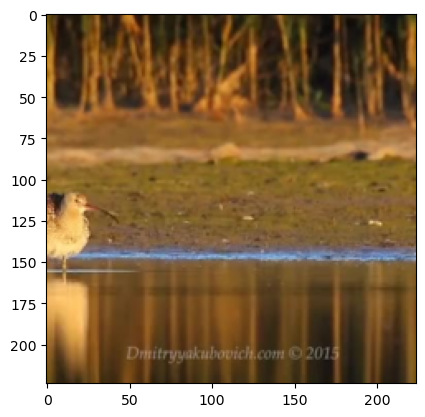

In [17]:
first_video, first_label = d[0]
first_frame = first_video[:,0,:,:]
first_frame = ((first_frame+1)/2)
plt.imshow(first_frame.transpose(1, 2, 0))

flipped axis: 0


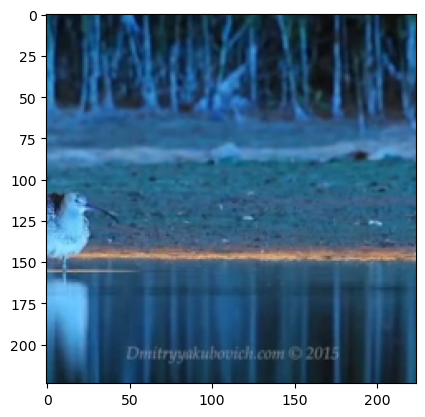

In [4]:
first_video, first_label = d[0]
first_frame = first_video[:,0,:,:]
first_frame = ((first_frame+1)/2)
plt.imshow(first_frame.transpose(1, 2, 0))

In [50]:
first_label

array([6], dtype=int8)

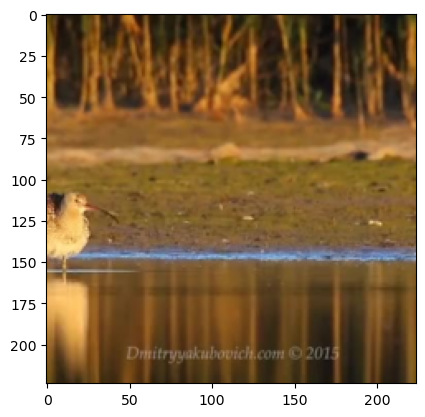

In [49]:
second_frame = first_video[:,15,:,:]
second_frame = ((second_frame+1)/2)
plt.imshow(first_frame.transpose(1, 2, 0))

no flipping


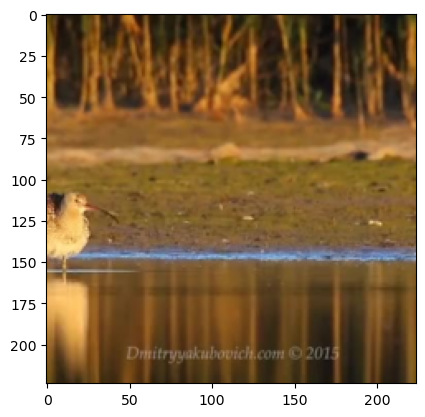

In [41]:
first_video, first_label = d[0]
first_frame = first_video[:,0,:,:]
first_frame = ((first_frame+1)/2)
plt.imshow(first_frame.transpose(1, 2, 0))

In [43]:
og = first_frame.copy()

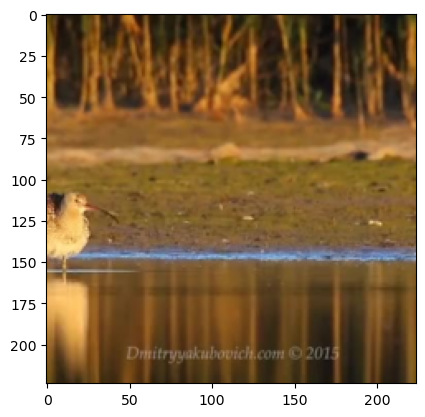

In [18]:
plt.imshow(first_frame.transpose(1, 2, 0))

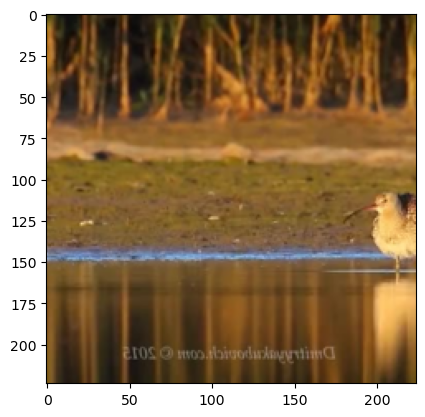

In [22]:
plt.imshow(np.flip(first_frame, axis=2).transpose(1, 2, 0))

flipped axis: 1


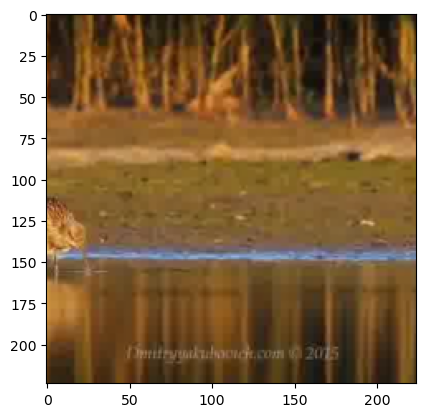

In [6]:
first_video, first_label = d[0]
first_frame = first_video[:,0,:,:]
first_frame = ((first_frame+1)/2)
plt.imshow(first_frame.transpose(1, 2, 0))

flipped axis: 2


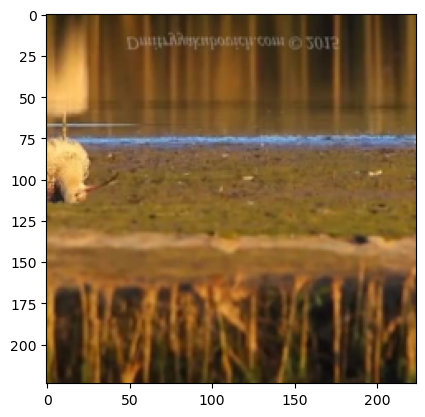

In [5]:
first_video, first_label = d[0]
first_frame = first_video[:,0,:,:]
first_frame = ((first_frame+1)/2)
plt.imshow(first_frame.transpose(1, 2, 0))

## testing data augmentation functions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


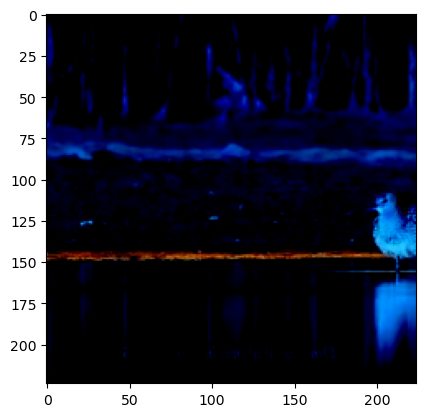

In [12]:
plt.imshow(np.flip(first_frame,axis=2).transpose(1,2,0))

Construct the model:

In [4]:
start_time = time.time() 
i3d = InceptionI3d(400, in_channels=3) # first input is num_classes 
i3d.load_state_dict(torch.load('rgb_imagenet.pt'))
num_classes = len(set(video_labels)) #count unique in labels
i3d.replace_logits(num_classes)
i3d.cuda()
print(f"time taken: {time.time()-start_time} seconds")

time taken: 1.3923192024230957 seconds


Function to evaluate model performance:

In [5]:
#returns accuracy, f1 score, average f1, and confusion matrix for the data
def eval_metrics(ground_truth, predictions, num_classes):

    #dictionary containing the accuracy, precision, f1, avg f1, and confusion matrix for the data
    f1 = f1_score(y_true=ground_truth, y_pred=predictions, average=None)
    metrics = {
        "accuracy": accuracy_score(y_true=ground_truth, y_pred=predictions),
        "f1": f1,
        "average f1": np.mean(f1),
        "confusion matrix": confusion_matrix(y_true=ground_truth, y_pred=predictions),
        "precision": precision_score(y_true=ground_truth, y_pred=predictions, average=None)
        }
    
    return metrics

Train:

In [7]:
metrics['precision']

NameError: name 'metrics' is not defined

In [6]:
# set up gradient descent params
optimizer = optim.SGD(i3d.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0000001) # weight_decay = l2 regularization
lr_sched = optim.lr_scheduler.MultiStepLR(optimizer, [300, 1000])

# set up training variables 
epochs = 2 # will need to increase later
tot_loss = 0.0
writer = SummaryWriter("deleteme")
step = 0
num_batches = np.ceil(num_videos/batch_size)

# train
for e in range(epochs):
    batch_num = 1
    start_time = time.time()
    for data, label in loader:
        data = data.cuda()
        label = label.squeeze().type(torch.LongTensor).cuda()
        num_frames = data.size(2)
        per_frame_logits = i3d(data).mean(2)
        preds = per_frame_logits.cpu().detach().numpy().argmax(axis=1) # convert logits into predictions for evaluating accuracy
        
        # calculate and save loss
        loss = F.cross_entropy(per_frame_logits, label) 
        writer.add_scalar("train/loss", loss.item(), step)
        
        # perform gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
        # print metrics every one epoch (at the last batch)
        if (batch_num == num_batches):
            metrics = eval_metrics(ground_truth = label.cpu().detach().numpy(), 
                                   predictions = preds, 
                                   num_classes = num_classes)
            print(f"epoch {e}:")
            print(f"loss: {loss}, accuracy: {round(metrics['accuracy'],2)}, f1 score: {round(metrics['average f1'],2)}")
            print(f"precision: \n{metrics['precision']}")
            print("confusion matrix:")
            print(metrics['confusion matrix']) 
        
        step+=1
        batch_num+=1
        
    print(f"Time taken for epoch {e}: {(time.time()-start_time)/60} mins")
    print("-----------------------------------------------------------------------")

writer.flush() # ensure that all loss values are recorded 

epoch 0:
loss: 2.269226551055908, accuracy: 0.4, f1 score: 0.3
precision: 
[0.         1.         0.33333333 0.         0.        ]
confusion matrix:
[[0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 1 1 0]]
Time taken for one epoch: 5.40993599096934 mins


/home/jt9744/.conda/envs/cos429/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 1:
loss: 0.9272324442863464, accuracy: 0.8, f1 score: 0.82
precision: 
[1.         0.66666667 1.        ]
confusion matrix:
[[1 1 0]
 [0 2 0]
 [0 0 1]]
Time taken for one epoch: 8.621792670090993 mins


save model

In [9]:
model_path = "models/baseline_2epochs"
torch.save(i3d, model_path)

Check saved output

In [10]:
torch.load(model_name)

InceptionI3d(
  (avg_pool): AvgPool3d(kernel_size=[2, 7, 7], stride=(1, 1, 1), padding=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (logits): Unit3D(
    (conv3d): Conv3d(1024, 11, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (Conv3d_1a_7x7): Unit3D(
    (conv3d): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), bias=False)
    (bn): BatchNorm3d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (MaxPool3d_2a_3x3): MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv3d_2b_1x1): Unit3D(
    (conv3d): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (Conv3d_2c_3x3): Unit3D(
    (conv3d): Conv3d(64, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(192, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (MaxPool3d_3a_3x3): MaxPool3dSam